In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json


%reload_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import glob
import matplotlib.font_manager as fm
from IPython.display import display, Image
import pickle
import random
from sklearn.model_selection import train_test_split

# カラム全表示
pd.set_option('max_columns',None)

# 小数点の設定
%precision 5

data_path = "data/"

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def extract_polarity(opinions):
    '''
    各文書の極性を多数決で決める
    '''
    polarities = np.array([-1, 0, 1])
    num_polarities = np.zeros(3)
    for i in range(len(opinions)):
        if opinions[i]["polarity"] == "negative":
            num_polarities[0] += 1
        if opinions[i]["polarity"] == "neutral":
            num_polarities[1] += 1
        if opinions[i]["polarity"] == "positive":
            num_polarities[2] += 1
    return polarities[num_polarities.argmax()]

In [3]:
# jsonファイルを取得
file_names  = glob.glob(data_path+"chABSA-dataset/*")
file_names = sorted(file_names)

In [254]:
f = open(file_names[0])
contents = json.load(f)

In [257]:
contents["sentences"][0]

{'opinions': [{'category': 'OOD#general',
   'from': 11,
   'polarity': 'neutral',
   'target': 'わが国経済',
   'to': 16},
  {'category': 'OOD#general',
   'from': 38,
   'polarity': 'positive',
   'target': '企業業績',
   'to': 42},
  {'category': 'OOD#general',
   'from': 43,
   'polarity': 'positive',
   'target': '雇用',
   'to': 45},
  {'category': 'OOD#general',
   'from': 46,
   'polarity': 'positive',
   'target': '所得環境',
   'to': 50},
  {'category': 'OOD#general',
   'from': 55,
   'polarity': 'positive',
   'target': '景気',
   'to': 57}],
 'sentence': '当連結会計年度におけるわが国経済は、政府の経済政策や日銀の金融緩和策により、企業業績、雇用・所得環境は改善し、景気も緩やかな回復基調のうちに推移いたしましたが、中国をはじめとするアジア新興国経済の減速懸念や、英国の欧州連合（ＥＵ）離脱決定、米国新政権への移行など、引き続き先行きは不透明な状況となっております',
 'sentence_id': 0}

In [4]:
sentences = []
polarities = []
for file_name in file_names:
    f = open(file_name)
    contents = json.load(f)
    for i in range(len(contents["sentences"])):
        # 一つのjsonファイルに格納されている文章の文と極性を取得
        target = contents["sentences"][i]
        if len(target["opinions"]) == 0:
            continue
        sentence = target["sentence"]
        polarity = extract_polarity(target["opinions"])


        sentences.append(sentence)
        polarities.append(polarity)

In [5]:
len(sentences), len(polarities)

(3215, 3215)

In [6]:
# 確認する
i = np.random.randint(len(sentences))
print(i)
sentences[i], polarities[i]

2882


('これらより、当連結会計年度における営業利益は、前年同期比16.4％減の5,134百万円(前年同期 6,140百万円)となりました', -1)

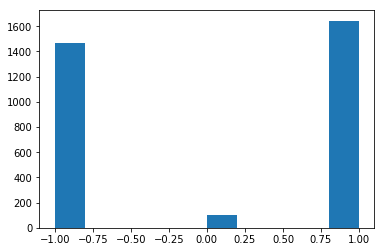

In [7]:
plt.hist(polarities)
plt.show()

In [262]:
len(np.where(polarities == 1)[0])

1644

In [8]:
# neutralを以外を用いる
sentences = []
polarities = []
for file_name in file_names:
    f = open(file_name)
    contents = json.load(f)
    for i in range(len(contents["sentences"])):
        # 一つのjsonファイルに格納されている文章の文と極性を取得
        target = contents["sentences"][i]
        if len(target["opinions"]) == 0:
            continue
        sentence = target["sentence"]
        polarity = extract_polarity(target["opinions"])
        if polarity == 0:
            continue

        sentences.append(sentence)
        polarities.append(polarity)

In [9]:
len(sentences), len(polarities)

(3114, 3114)

In [136]:
polarities = np.array(polarities)
polarities[np.where(polarities == -1)] = 0

In [200]:
# with open("data/sentences.pickle", "wb") as f:
#     pickle.dump(sentences,f)
# with open("data/polarities.pickle", "wb") as f:
#     pickle.dump(polarities,f)

with open("data/sentences.pickle", "rb") as f:
    sentences = pickle.load(f)
with open("data/polarities.pickle", "rb") as f:
    polarities = pickle.load(f)

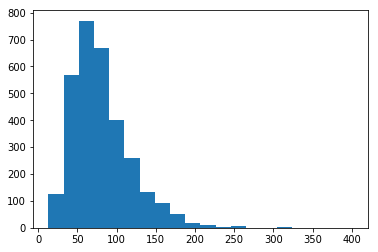

In [201]:
# 文字列の打ち切りサイズを考える
sentences_lens = [len(sentence )for sentence in sentences]
plt.hist(sentences_lens, bins=20)
plt.show()

In [202]:
# 文字をUNICODEに変換する
max_length = 150
encoded_sentences = []
for sentence in sentences:
    # 文字毎にUNICODEに変換
    encoded_sentence = [ord(x) for x  in sentence]

    # 長すぎる文章は打ち切る
    encoded_sentence = encoded_sentence[:max_length]
    # 固定長にするための0パディング
    sentence_len = len(encoded_sentence)
    if sentence_len < max_length:
        encoded_sentence  += ([0] * (max_length - sentence_len))
        
    encoded_sentences.append(encoded_sentence)
    
encoded_sentences = np.array(encoded_sentences)

### 学習モデル

In [203]:
import keras
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Convolution2D, MaxPooling2D, concatenate, BatchNormalization, Dense, Dropout

In [232]:
def create_model(embed_size=128, max_length=150, filter_sizes=(2, 3, 4, 5), filter_num=64):
    inp = Input(shape=(max_length,))
    emb = Embedding(0xffff, embed_size)(inp)
    emb_ex = Reshape((max_length, embed_size, 1))(emb)
    convs = []
    # Convolution2Dを複数通りかける
    for filter_size in filter_sizes:
        conv = Convolution2D(filter_num, filter_size, embed_size, activation="relu")(emb_ex)
        pool = MaxPooling2D(pool_size=(max_length - filter_size + 1, 1))(conv)
        convs.append(pool)
    if len(filter_sizes) == 1:
        reshape = Reshape((filter_num * 1,))(convs[0])
        fc1 = Dense(64, activation="relu")(reshape)
        bn1 = BatchNormalization()(fc1)
        do1 = Dropout(0.5)(bn1)
        fc2 = Dense(1, activation='sigmoid')(do1)
        model = Model(input=inp, output=fc2)
    else:
        convs_merged = concatenate(convs, axis=-1)
        reshape = Reshape((filter_num * len(filter_sizes),))(convs_merged)
        fc1 = Dense(64, activation="relu")(reshape)
        bn1 = BatchNormalization()(fc1)
        do1 = Dropout(0.5)(bn1)
        fc2 = Dense(1, activation='sigmoid')(do1)
        model = Model(input=inp, output=fc2)

    return model

### 学習

In [205]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
models_path = "models/"

In [206]:
X_train, X_test, Y_train, Y_test = train_test_split(encoded_sentences, polarities, test_size=0.2)

In [224]:
def train(inputs, targets, batch_size=100, epoch_count=100, max_length=150, filter_sizes = (2,3,4,5), model_filepath="models/model.h5", learning_rate=0.001):

    # 学習率を少しずつ下げるようにする
    start = learning_rate
    stop = learning_rate * 0.01
    learning_rates = np.linspace(start, stop, epoch_count)

    # モデル作成
    model = create_model(max_length=max_length, filter_sizes=filter_sizes)
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # 学習
    fit = model.fit(inputs, targets,
              nb_epoch=epoch_count,
              batch_size=batch_size,
              verbose=1,
              validation_split=0.1,
              shuffle=True,
              callbacks=[
                  LearningRateScheduler(lambda epoch: learning_rates[epoch]),
              ])

    # モデルの保存
    model.save(model_filepath)
    return fit

In [231]:
X_train

array([[12414, 12383, 12289, ...,     0,     0,     0],
       [20197, 19978, 12398, ...,     0,     0,     0],
       [12501, 12449, 12452, ...,     0,     0,     0],
       ...,
       [12371, 12398, 32080, ...,     0,     0,     0],
       [24403, 37096, 38272, ...,     0,     0,     0],
       [12371, 12428, 12425, ...,     0,     0,     0]])

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/10
2241/2241 [==============================] - 7s 3ms/step - loss: 0.5306 - acc: 0.7515 - val_loss: 0.4374 - val_acc: 0.8160
Epoch 2/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.3598 - acc: 0.8492 - val_loss: 0.3854 - val_acc: 0.8280
Epoch 3/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.2956 - acc: 0.8853 - val_loss: 0.3800 - val_acc: 0.8280
Epoch 4/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.2375 - acc: 0.9090 - val_loss: 0.4280 - val_acc: 0.7760
Epoch 5/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.2025 - acc: 0.9268 - val_loss: 0.3629 - val_acc: 0.8240
Epoch 6/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.1643 - acc: 0.9473 - val_loss: 0.3580 - val_acc: 0.8160
Epoch 7/10
2241/2241 [==============================] - 2s 1ms/step - loss: 0.1413 - acc: 0.9612 - val_loss: 0.3981 - val_acc: 0.7920
Epoch 8/10
2241

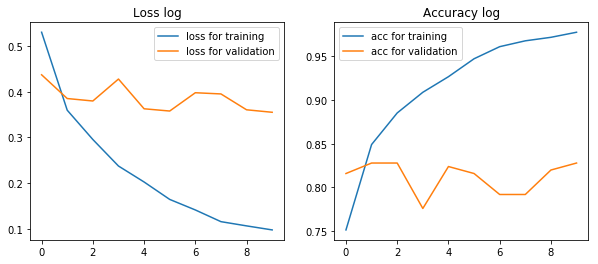

0.96469

In [235]:
model_name = models_path+"filter_2.h5"
fit = train(X_train, Y_train, epoch_count=10, filter_sizes = (2,), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test)).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/50
2241/2241 [==============================] - 8s 4ms/step - loss: 0.5614 - acc: 0.7247 - val_loss: 0.4453 - val_acc: 0.8200
Epoch 2/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3770 - acc: 0.8394 - val_loss: 0.3658 - val_acc: 0.8680
Epoch 3/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2932 - acc: 0.8804 - val_loss: 0.3420 - val_acc: 0.8880
Epoch 4/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2332 - acc: 0.9067 - val_loss: 0.3352 - val_acc: 0.8800
Epoch 5/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1880 - acc: 0.9282 - val_loss: 0.5141 - val_acc: 0.7640
Epoch 6/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1448 - acc: 0.9527 - val_loss: 0.3915 - val_acc: 0.8600
Epoch 7/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1047 - acc: 0.9674 - val_loss: 0.5369 - val_acc: 0.7920
Epoch 8/50
2241

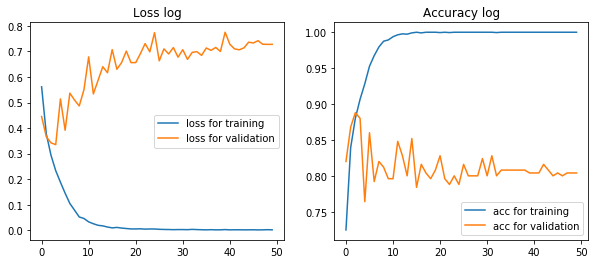

0.86196

In [242]:
model_name = models_path+"filter_2.h5"
fit = train(X_train, Y_train, epoch_count=50, filter_sizes = (2,), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/50
2241/2241 [==============================] - 9s 4ms/step - loss: 0.5310 - acc: 0.7372 - val_loss: 0.6049 - val_acc: 0.7320
Epoch 2/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3537 - acc: 0.8581 - val_loss: 0.5067 - val_acc: 0.7440
Epoch 3/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2586 - acc: 0.9000 - val_loss: 0.3540 - val_acc: 0.8480
Epoch 4/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1844 - acc: 0.9349 - val_loss: 0.3828 - val_acc: 0.8520
Epoch 5/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1139 - acc: 0.9665 - val_loss: 0.4019 - val_acc: 0.8360
Epoch 6/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0719 - acc: 0.9835 - val_loss: 0.4772 - val_acc: 0.8160
Epoch 7/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0431 - acc: 0.9938 - val_loss: 0.4627 - val_acc: 0.8320
Epoch 8/50
2241

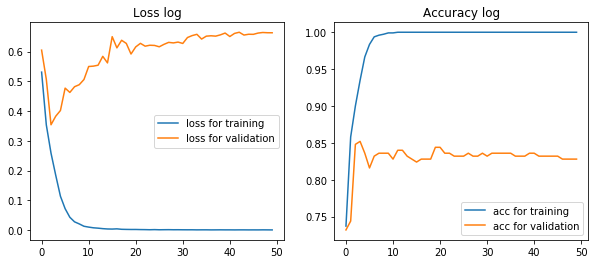

0.86677

In [244]:
model_name = models_path+"filter_23.h5"
fit = train(X_train, Y_train, epoch_count=50, filter_sizes = (2,3), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/50
2241/2241 [==============================] - 10s 4ms/step - loss: 0.5157 - acc: 0.7474 - val_loss: 0.4228 - val_acc: 0.8360
Epoch 2/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3153 - acc: 0.8719 - val_loss: 0.3895 - val_acc: 0.8160
Epoch 3/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2406 - acc: 0.9085 - val_loss: 0.3417 - val_acc: 0.8520
Epoch 4/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1592 - acc: 0.9482 - val_loss: 0.3315 - val_acc: 0.8720
Epoch 5/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0968 - acc: 0.9759 - val_loss: 0.3504 - val_acc: 0.8720
Epoch 6/50
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0674 - acc: 0.9866 - val_loss: 0.4203 - val_acc: 0.8480
Epoch 7/50
2241/2241 [==============================] - 3s 2ms/step - loss: 0.0349 - acc: 0.9960 - val_loss: 0.4313 - val_acc: 0.8480
Epoch 8/50
224

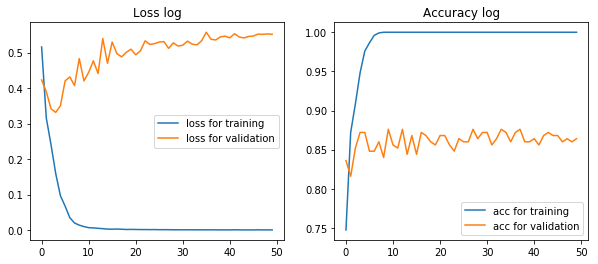

0.88122

In [245]:
model_name = models_path+"filter_234.h5"
fit = train(X_train, Y_train, epoch_count=50, filter_sizes = (2,3,4), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Ten

Train on 2241 samples, validate on 250 samples
Epoch 1/50
2241/2241 [==============================] - 11s 5ms/step - loss: 0.4934 - acc: 0.7546 - val_loss: 0.4449 - val_acc: 0.7760
Epoch 2/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.2979 - acc: 0.8746 - val_loss: 0.3548 - val_acc: 0.8280
Epoch 3/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.2024 - acc: 0.9282 - val_loss: 0.3923 - val_acc: 0.8520
Epoch 4/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.1234 - acc: 0.9612 - val_loss: 0.3115 - val_acc: 0.8680
Epoch 5/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.0690 - acc: 0.9866 - val_loss: 0.3320 - val_acc: 0.8760
Epoch 6/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.0390 - acc: 0.9951 - val_loss: 0.3177 - val_acc: 0.8600
Epoch 7/50
2241/2241 [==============================] - 4s 2ms/step - loss: 0.0218 - acc: 0.9982 - val_loss: 0.4444 - val_acc: 0.8360
Epoch 8/50
224

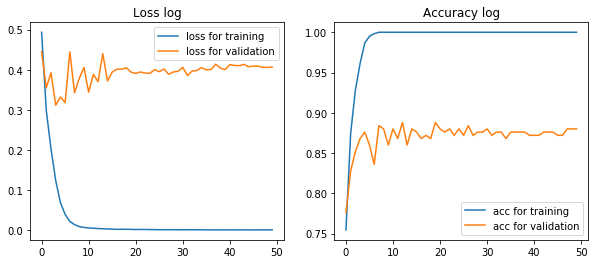

0.87801

In [246]:
model_name = models_path+"filter_2345.h5"
fit = train(X_train, Y_train, epoch_count=50, filter_sizes = (2,3,4,5), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

### epochs短く

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/10
2241/2241 [==============================] - 10s 4ms/step - loss: 0.6154 - acc: 0.6667 - val_loss: 0.4549 - val_acc: 0.8200
Epoch 2/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.4135 - acc: 0.8188 - val_loss: 0.3769 - val_acc: 0.8520
Epoch 3/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3290 - acc: 0.8759 - val_loss: 0.3359 - val_acc: 0.8520
Epoch 4/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2690 - acc: 0.9085 - val_loss: 0.3078 - val_acc: 0.8720
Epoch 5/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2186 - acc: 0.9232 - val_loss: 0.3179 - val_acc: 0.8600
Epoch 6/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1872 - acc: 0.9375 - val_loss: 0.2929 - val_acc: 0.8840
Epoch 7/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1574 - acc: 0.9531 - val_loss: 0.3037 - val_acc: 0.8720
Epoch 8/10
224

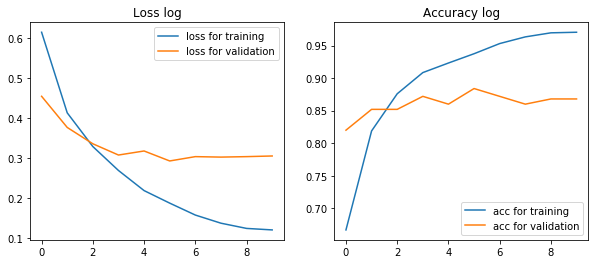

0.85714

In [248]:
model_name = models_path+"filter_2_10.h5"
fit = train(X_train, Y_train, epoch_count=10, filter_sizes = (2,), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/10
2241/2241 [==============================] - 11s 5ms/step - loss: 0.5304 - acc: 0.7434 - val_loss: 0.4346 - val_acc: 0.8240
Epoch 2/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3514 - acc: 0.8577 - val_loss: 0.3696 - val_acc: 0.8360
Epoch 3/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2774 - acc: 0.8884 - val_loss: 0.3368 - val_acc: 0.8360
Epoch 4/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2136 - acc: 0.9282 - val_loss: 0.3899 - val_acc: 0.8160
Epoch 5/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1692 - acc: 0.9451 - val_loss: 0.3283 - val_acc: 0.8480
Epoch 6/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1291 - acc: 0.9647 - val_loss: 0.3315 - val_acc: 0.8320
Epoch 7/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1008 - acc: 0.9804 - val_loss: 0.3398 - val_acc: 0.8440
Epoch 8/10
224

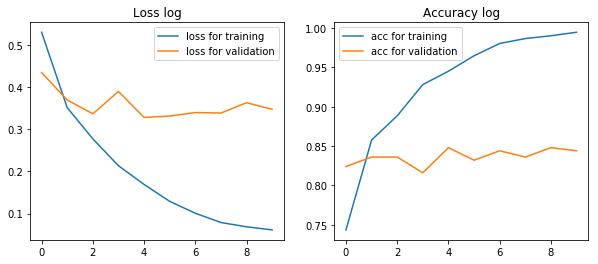

0.85875

In [249]:
model_name = models_path+"filter_23_10.h5"
fit = train(X_train, Y_train, epoch_count=10, filter_sizes = (2,3), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2241 samples, validate on 250 samples
Epoch 1/10
2241/2241 [==============================] - 11s 5ms/step - loss: 0.5217 - acc: 0.7470 - val_loss: 0.4382 - val_acc: 0.8160
Epoch 2/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.3342 - acc: 0.8670 - val_loss: 0.3599 - val_acc: 0.8440
Epoch 3/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.2405 - acc: 0.9157 - val_loss: 0.4835 - val_acc: 0.7720
Epoch 4/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1824 - acc: 0.9380 - val_loss: 0.4064 - val_acc: 0.7920
Epoch 5/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.1284 - acc: 0.9670 - val_loss: 0.3720 - val_acc: 0.8160
Epoch 6/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0864 - acc: 0.9830 - val_loss: 0.4100 - val_acc: 0.8000
Epoch 7/10
2241/2241 [==============================] - 3s 1ms/step - loss: 0.0642 - acc: 0.9920 - val_loss: 0.4166 - val_acc: 0.8120
Epoch 8/10
224

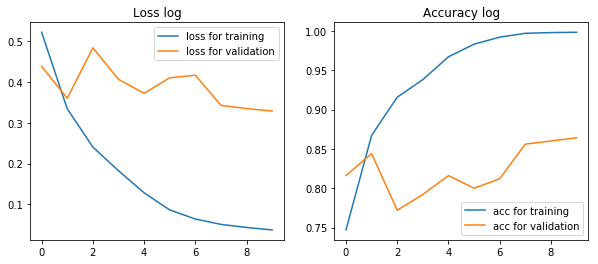

0.87480

In [250]:
model_name = models_path+"filter_234_10.h5"
fit = train(X_train, Y_train, epoch_count=10, filter_sizes = (2,3,4), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 128), activation="relu")`
  
/home/k-syo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Ten

Train on 2241 samples, validate on 250 samples
Epoch 1/10
2241/2241 [==============================] - 12s 6ms/step - loss: 0.5254 - acc: 0.7425 - val_loss: 0.4137 - val_acc: 0.8280
Epoch 2/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.3413 - acc: 0.8688 - val_loss: 0.3999 - val_acc: 0.8120
Epoch 3/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.2593 - acc: 0.9072 - val_loss: 0.3256 - val_acc: 0.8400
Epoch 4/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.1878 - acc: 0.9402 - val_loss: 0.3662 - val_acc: 0.8280
Epoch 5/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.1357 - acc: 0.9710 - val_loss: 0.3138 - val_acc: 0.8520
Epoch 6/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.0964 - acc: 0.9830 - val_loss: 0.2844 - val_acc: 0.8880
Epoch 7/10
2241/2241 [==============================] - 4s 2ms/step - loss: 0.0627 - acc: 0.9964 - val_loss: 0.3276 - val_acc: 0.8440
Epoch 8/10
224

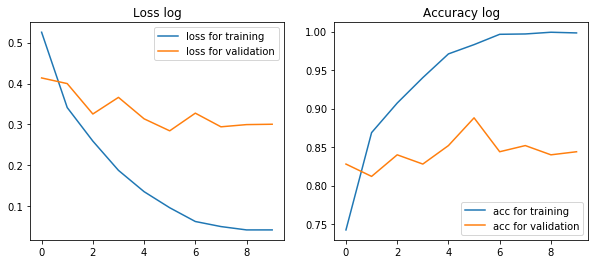

0.87801

In [251]:
model_name = models_path+"filter_2345_10.h5"
fit = train(X_train, Y_train, epoch_count=10, filter_sizes = (2,3,4,5), model_filepath=model_name)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(fit.history['loss'],label="loss for training")
axL.plot(fit.history['val_loss'],label="loss for validation")
axL.legend()
axL.set_title("Loss log")

axR.plot(fit.history['acc'],label="acc for training")
axR.plot(fit.history['val_acc'],label="acc for validation")
axR.set_title("Accuracy log")
axR.legend()

plt.show()

# テストデータに対する精度
ret = predict(np.array(X_test),model_filepath=model_name).reshape(-1)
accuracy_score(Y_test, np.round(ret))

### 確認

In [263]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [264]:
def predict(comments, model_filepath="models/model.h5"):
    model = load_model(model_filepath)
    ret = model.predict(comments)
    return ret

In [267]:
model_name = models_path+"filter_2345.h5"
ret = predict(np.array(X_test), model_filepath=model_name).reshape(-1)

In [278]:
target = np.random.choice(np.arange(len(sentences)), 10)

In [282]:
model_name = models_path+"filter_2345.h5"
ret = predict(np.array(encoded_sentences[target, :]), model_filepath=model_name).reshape(-1)

In [289]:
np.round(ret)

array([1., 0., 1., 0., 1., 1., 0., 1., 1., 1.], dtype=float32)

In [287]:
np.array(sentences)[target]

array(['この結果、当連結会計年度における営業収益は、前連結会計年度と比較して0.5％、99百万円増加して21,871百万円となりましたが、営業損益は、人件費の増加や新車導入に伴う償却費の増加等の影響により、前連結会計年度771百万円の営業損失に対し、1,102百万円の営業損失となりました',
       '官公庁の工事発注量の減少及び入札競争の激化による受注数の減少、民間設備投資の停滞、工事案件の大型化による仕掛工事の増加により当連結会計年度の施工事業の売上高は前年同期に比べて３億11百万円減少し、５億84百万円（前連結会計年度比34.8％減）となりました',
       'このような事業環境の下、当社グループは、主力市場である車載分野においてはグローバルでの販売活動が功を奏し、電装化や安全運転支援技術の進歩によるADAS（先進運転支援システム）の普及増により、車載カメラ、ミリ波レーダー向けが堅調に推移し、パワートレイン系では三次元可動BtoBコネクタ“Z-Move™”の販売が増加しました',
       'その結果、売上高は12,205百万円(前年同期比1.7％増加)、セグメント損失は254百万円(前年同期は725百万円の損失)となりました',
       '日本医師会・日本薬剤師会・日本大学との共同研究である「感染症流行探知サービス」におきましては、利用薬局は全国で１万件超となっております',
       '売上については、「合味道」および「香港製造出前一丁」が引き続き順調に推移しておりますが、為替の影響もあったことから前期を下回りました',
       '当連結会計年度におけるわが国経済は、政府の各種経済政策による下支えはあるものの本格的な景気浮揚には至っておらず、懸案であった個人消費の回復によるデフレ脱却という課題も充分達成されたとは言い難い状況であります',
       '運用・保守業務は、特定顧客向けの業務受託量が増加したことに加えて、「ＮＶＩＤＩＡ社」の保守サポート業務を開始したことにより、売上高、利益ともに増加致しました',
       '当連結会計年度におけるわが国経済は、欧米先進国での景況感の改善傾向や中国・アジア新興国での景気の持ち直しなどがあった一方、米国新政権が主導する経済政策の実現可能性への懸念もあり、先行き不透明

In [296]:
for i in range(10):
    print(np.array(sentences)[target][i])
    print("Predict : "+str(np.round(ret)[i])+", GrandTrue : "+str(polarities[target][i]))
    print()

この結果、当連結会計年度における営業収益は、前連結会計年度と比較して0.5％、99百万円増加して21,871百万円となりましたが、営業損益は、人件費の増加や新車導入に伴う償却費の増加等の影響により、前連結会計年度771百万円の営業損失に対し、1,102百万円の営業損失となりました
Predict : 1.0, GrandTrue : 0

官公庁の工事発注量の減少及び入札競争の激化による受注数の減少、民間設備投資の停滞、工事案件の大型化による仕掛工事の増加により当連結会計年度の施工事業の売上高は前年同期に比べて３億11百万円減少し、５億84百万円（前連結会計年度比34.8％減）となりました
Predict : 0.0, GrandTrue : 0

このような事業環境の下、当社グループは、主力市場である車載分野においてはグローバルでの販売活動が功を奏し、電装化や安全運転支援技術の進歩によるADAS（先進運転支援システム）の普及増により、車載カメラ、ミリ波レーダー向けが堅調に推移し、パワートレイン系では三次元可動BtoBコネクタ“Z-Move™”の販売が増加しました
Predict : 1.0, GrandTrue : 1

その結果、売上高は12,205百万円(前年同期比1.7％増加)、セグメント損失は254百万円(前年同期は725百万円の損失)となりました
Predict : 0.0, GrandTrue : 0

日本医師会・日本薬剤師会・日本大学との共同研究である「感染症流行探知サービス」におきましては、利用薬局は全国で１万件超となっております
Predict : 1.0, GrandTrue : 1

売上については、「合味道」および「香港製造出前一丁」が引き続き順調に推移しておりますが、為替の影響もあったことから前期を下回りました
Predict : 1.0, GrandTrue : 1

当連結会計年度におけるわが国経済は、政府の各種経済政策による下支えはあるものの本格的な景気浮揚には至っておらず、懸案であった個人消費の回復によるデフレ脱却という課題も充分達成されたとは言い難い状況であります
Predict : 0.0, GrandTrue : 0

運用・保守業務は、特定顧客向けの業務受託量が増加したことに加えて、「ＮＶＩＤＩＡ社」の保守サポート業務を

In [285]:
sentences[target]

TypeError: only integer scalar arrays can be converted to a scalar index

In [273]:
test = random.sample(sentences, 10)

In [156]:
X_test[]

0.86196

In [ ]:
### LSTMだったとしたら？

In [ ]:
def create_model(embed_size=128, max_length=150, filter_sizes=(2, 3, 4, 5), filter_num=64):
    inp = Input(shape=(max_length,))
    emb = Embedding(0xffff, embed_size)(inp)
    emb_ex = Reshape((max_length, embed_size, 1))(emb)
    convs = []
    # Convolution2Dを複数通りかける
    for filter_size in filter_sizes:
        conv = Convolution2D(filter_num, filter_size, embed_size, activation="relu")(emb_ex)
        pool = MaxPooling2D(pool_size=(max_length - filter_size + 1, 1))(conv)
        convs.append(pool)
    if len(filter_sizes) == 1:
        reshape = Reshape((filter_num * 1,))(convs[0])
        fc1 = Dense(64, activation="relu")(reshape)
        bn1 = BatchNormalization()(fc1)
        do1 = Dropout(0.5)(bn1)
        fc2 = Dense(1, activation='sigmoid')(do1)
        model = Model(input=inp, output=fc2)
    else:
        convs_merged = concatenate(convs, axis=-1)
        reshape = Reshape((filter_num * len(filter_sizes),))(convs_merged)
        fc1 = Dense(64, activation="relu")(reshape)
        bn1 = BatchNormalization()(fc1)
        do1 = Dropout(0.5)(bn1)
        fc2 = Dense(1, activation='sigmoid')(do1)
        model = Model(input=inp, output=fc2)

    return model